In [66]:
# Imports
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy

%matplotlib inline
plt.style.use('bmh')

In [67]:
#below all subdirectories are searched for data files

all_files = []
file_end = 'segments.csv'
def read(root):
    for (dir_path, dir_names, files) in os.walk(root):
        for file in files:
             if file.lower().endswith(file_end.lower()):
                paths= re.split(r"[/\\]", dir_path.lower())
                df = pd.read_csv(os.path.join(dir_path, file),
                                 )#names=["bwd_path0","bwd_path1","srtt_path0","srtt_path1","loss_path0","loss_path1"]
                #print(file)
                df['trace'] = int(file.split("_")[0])
                df['model'] = paths[-2].split("_")[-2]
                #based on subdirectory, is the download a video or a file
                #df['download_type'] = paths[2]
    #
                ##based on subdirectory, what type of mobility are the traces
                #df['trace_mobility'] = paths[3]
    #
                #df['TraceID'] = len(all_files) #each file is a separate trace
                all_files.append(df)
old_lstm = "central_service/runs/20230528_11_22_27_LSTM_test/"
new_lstm = "central_service/runs/20230529_10_15_43_LSTM_test/"
min_rtt = 'central_service/runs/20230529_11_01_43_minrtt_test/'
a2c = "central_service/runs/20230530_00_45_43_a2c_test/"

runs = [old_lstm, min_rtt, a2c]
for r in runs:
    read(r)
df_runs = pd.concat(all_files, ignore_index=True)
#df_runs

In [68]:
traces = pd.read_csv("central_service/test_traces.csv")
traces['mobility'] = (traces['Trace1'] == 'wifi') | (traces['Trace2'] == 'wifi')
traces['mobility'] = traces['mobility'].apply(lambda x: 'static' if x else 'mobile')
traces = traces.rename(columns={traces.columns[0]: 'trace'}, errors="raise")
traces = traces[['trace', 'mobility']]
traces

,trace,mobility
0,0,mobile
1,1,mobile
2,2,mobile
3,3,mobile
4,4,mobile
5,5,static
6,6,mobile
7,7,mobile
8,8,mobile
9,9,static


In [69]:
df_runs = df_runs.merge(traces, on='trace')
trace_qoe = df_runs.groupby(['trace', 'model']).agg({'qoe':'last'}).reset_index().rename(columns={'qoe':'trace_qoe'}, errors="raise")
df_runs = df_runs.merge(trace_qoe, on=['trace', 'model'])
df_runs
#trace_qoe

,Unnamed: 0,segment_nr,bandwidth,bitrate,down_shifts,buffering_ratio,initial_buffering,stall_count,stall_sum,qoe,trace,model,mobility,trace_qoe
0,0,0,1502.066519,247444,0,0.000000,0.785746,0,0.000000,0.239470,0,lstm,mobile,1.411736
1,1,1,348054.404177,247444,0,0.000000,0.000000,0,0.000000,0.239470,0,lstm,mobile,1.411736
2,2,2,457241.382155,247444,0,0.000000,0.000000,0,0.000000,0.239470,0,lstm,mobile,1.411736
3,3,3,339127.923882,247444,0,0.000000,0.000000,0,0.000000,0.239470,0,lstm,mobile,1.411736
4,4,4,497996.997446,494206,0,0.000000,0.000000,0,0.000000,0.220483,0,lstm,mobile,1.411736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8965,294,294,802803.693282,6013501,3,0.009870,0.000000,4,5.718458,0.000000,9,a2c,static,0.000000
8966,295,295,995510.178407,10063789,0,0.009857,0.000000,4,5.718458,0.000000,9,a2c,static,0.000000
8967,296,296,949811.147106,15144115,0,0.009832,0.000000,4,5.718458,0.000000,9,a2c,static,0.000000
8968,297,297,981518.663909,15144115,0,0.009806,0.000000,4,5.718458,0.000000,9,a2c,static,0.000000


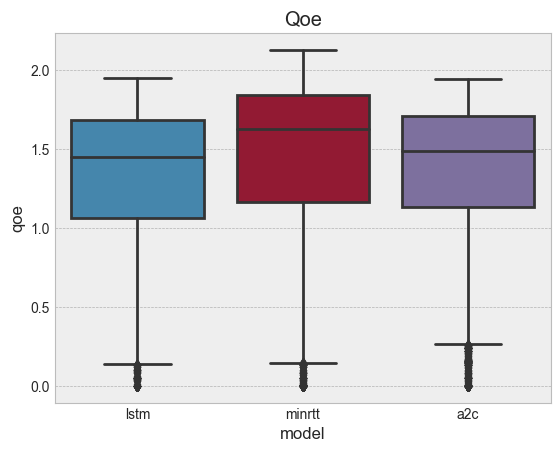

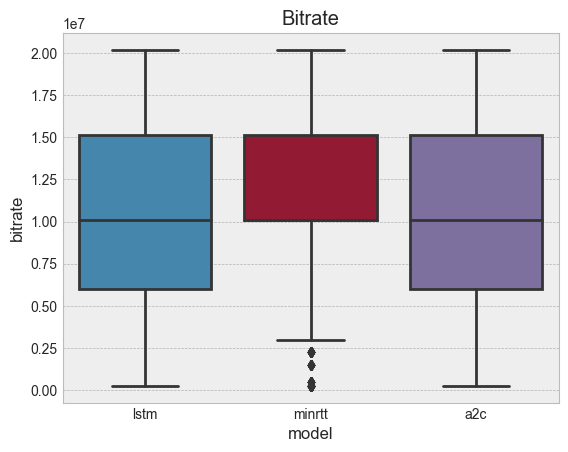

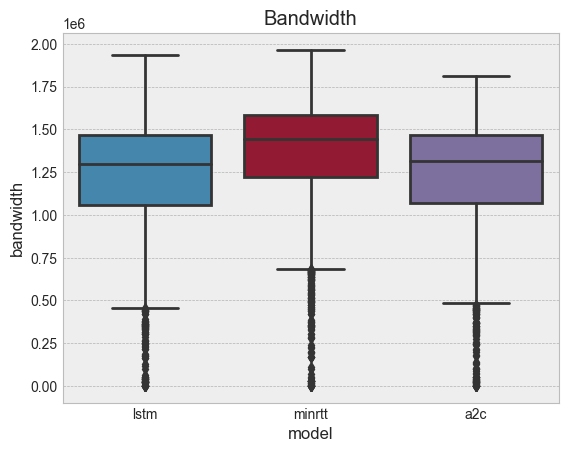

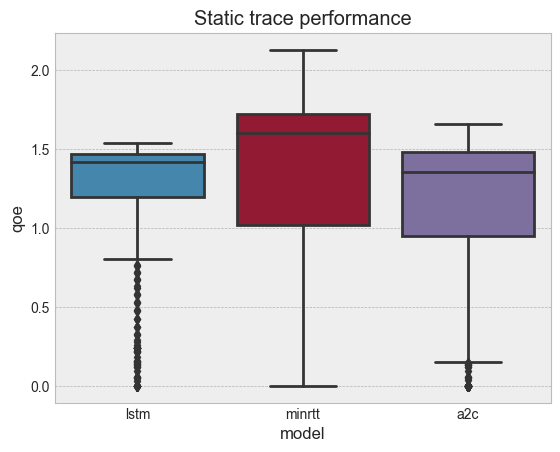

<Axes: xlabel='segment_nr'>

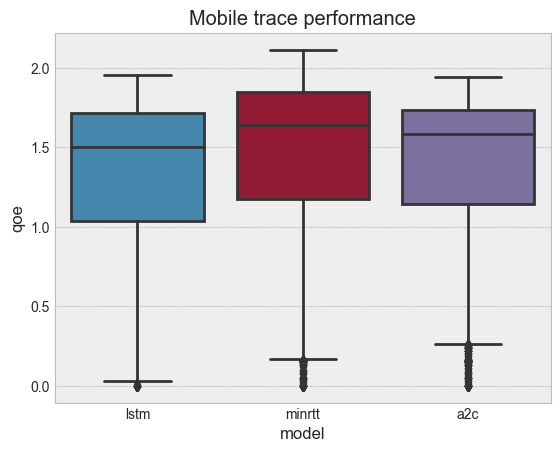

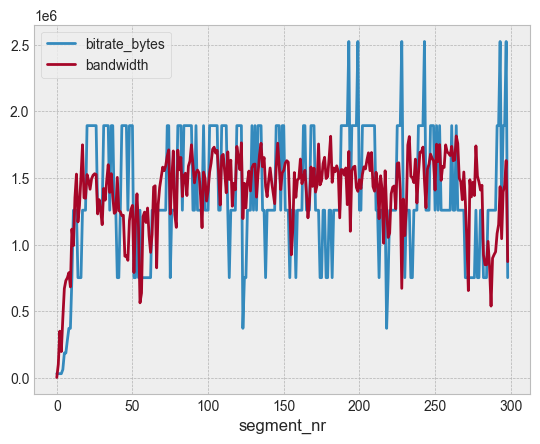

In [103]:
#df_runs = df_runs[df_runs['trace']<4]

#df_runs.groupby(['trace', 'model']).agg({'qoe':'last', 'bitrate':'mean'})
#df_runs.groupby(['model']).agg({'bandwidth':'mean'})
#df_runs.groupby(['model']).agg({'trace_qoe':'mean'})
#df_runs.groupby(['model']).plot(x='model', y='trace_qoe', kind='box')
#plt.boxplot(x=df_runs['model'], y='trace_qoe')
sns.boxplot(data=df_runs, x='model', y='qoe', orient='v')
plt.title('Qoe')
plt.show()
sns.boxplot(data=df_runs, x='model', y='bitrate', orient='v')
plt.title('Bitrate')
plt.show()
sns.boxplot(data=df_runs, x='model', y='bandwidth', orient='v')
plt.title('Bandwidth')
plt.show()
sns.boxplot(data=df_runs[df_runs['mobility']=='static'], x='model', y='qoe')
plt.title('Static trace performance')
plt.show()
sns.boxplot(data=df_runs[df_runs['mobility']=='mobile'], x='model', y='qoe')
plt.title('Mobile trace performance')

df_runs['bitrate_bytes'] = df_runs['bitrate']/8
df_runs[(df_runs['model']=='minrtt') & (df_runs['trace']==2)].plot(x='segment_nr', y=['bitrate_bytes', 'bandwidth']) #, kind='scatter'
#df_runs.groupby(['trace', 'model']).agg({'bwd_path0':'mean'})

In [ ]:
df_runs.groupby(['trace', 'model']).agg({'qoe':'last', 'bitrate':'mean'})

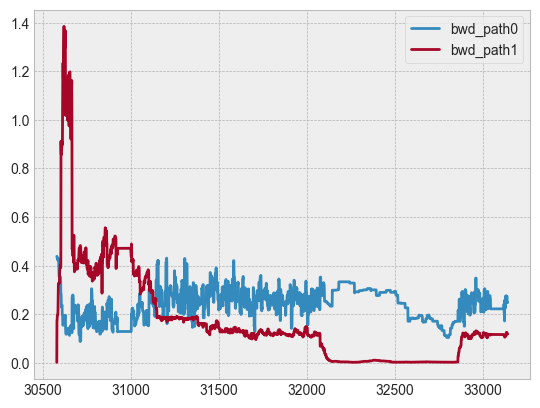

<Axes: >

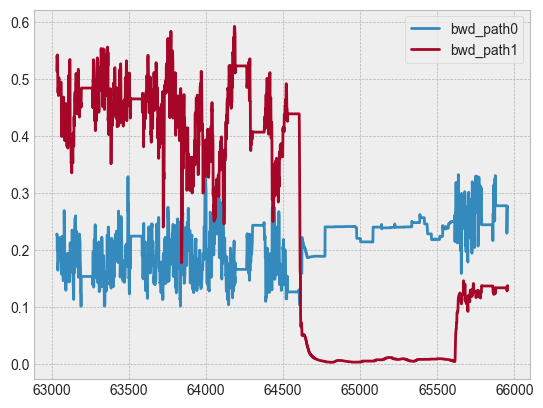

In [45]:
#df_runs[(df_runs['model']=='lstm') & (df_runs['trace']=='9')][['bwd_path0','bwd_path1']].plot()
#plt.show()
#df_runs[(df_runs['model']=='minrtt') & (df_runs['trace']=='9')][['bwd_path0','bwd_path1']].iloc[100:].plot()